# Load libraries 

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# 1. Load Data

In [143]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


### Missing values 

### Convert the categorical variable to numerical variable 

The categorical variable 'EJ' is converted into two dummy variables and we only need to keep one for modeling. We keep column 'A'.

Rename the original 'train' data as 'train_new'

In [135]:
def con_dum(df,new_df):
    dummies= pd.get_dummies(df.EJ)
    dummies = dummies.A
    
    # column bind the new dummy df to the original train data 
    new_df = pd.concat([df, dummies], axis=1)
    
    # drop original categorical column 'EJ'
    new_df = new_df.drop(['EJ'], axis=1) 

In [101]:
# a function to check if the original column still there or not 
def check(col,df):
   if col in df:
      print ("Column", col, "exists in the DataFrame.")
   else:
      print ("Column", col, "does not exist in the DataFrame.")


In [145]:
# generate a dummy column 'A' for train data and name the df as 'train_new'
con_dum(train,train_new)

In [147]:
# repeat the same process for test data 

dummies= pd.get_dummies(test.EJ)
dummies = dummies.A

# column bind the new dummy df to the original train data 
test_new = pd.concat([test, dummies], axis=1)
    
# drop original categorical column 'EJ'
test_new = test_new.drop(['EJ'], axis=1) 

# check if EJ still exists in the new train dataset or not 
col = 'EJ'
df= test_new

check(col,df)

Column EJ does not exist in the DataFrame.


# Deal with missing values 

In [152]:
# replace the NaN with mean for all features with missing values 
dtrain = train_new.fillna(train_new.median()) 
dtest = test_new.fillna(test_new.median()) 

In [155]:
# print(dtest.isnull().sum()) # there are multiple features that have missing values 


### Datasets that are ready for use are 'train_new' and 'test_new'


# 2. Splitting Data into train and test

In [208]:
target = dtrain[['Class']]
attributes = dtrain.drop(['Class','Id'], axis = 1)

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [157]:
X = attributes
y = target
#training set = 75% testing set = 25%
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.25, random_state = 10)

In [158]:
print(X_train.shape, y_train.shape)

(462, 56) (462,)


In [159]:
print(X_test.shape, y_test.shape)

(155, 56) (155,)


During EDA the different features were identified to vary significantly in scale. As a consequence the training and the testing set for this model will be scaled prior to fitting and prediticting.

In [160]:
# assuming data is normally distributed
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Training

### Import libraries for evaluating data

In [84]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_validate, learning_curve, validation_curve, RandomizedSearchCV, StratifiedKFold
#from bayes_opt import BayesianOptimization
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

## 4.1 Dummy Classifier

In [85]:
from sklearn.dummy import DummyClassifier

model_dummy = DummyClassifier(random_state=100)
model_dummy.fit(X_train_scaled, y_train)
print('Confusion Matrix: \n', confusion_matrix(y_test, model_dummy.predict(X_test_scaled)))
print('Classification Report: ', classification_report(y_test, model_dummy.predict(X_test_scaled)))
#print('MCC: ', matthews_corrcoef(y_test, model_dummy.predict(X_test)));


# Comments
The dummy classifier gives an accuracy score of 73%. This is a baseline score to compare suitable models to.

## 4.2 Logistic Regression 

### 4.2.1 Logistic Regression 

In [93]:
from sklearn.linear_model import LogisticRegression

In [162]:
model_log = LogisticRegression(random_state = 10)
model_log.fit(X_train_scaled, y_train)
predictions_log = model_log.predict(X_test_scaled)

In [163]:
print('Confusion Matrix: \n',confusion_matrix(y_test, predictions_log))
print('Classification Report: \n',classification_report(y_test, predictions_log))
print('MCC: ',matthews_corrcoef(y_test, predictions_log))


Confusion Matrix: 
 [[129   6]
 [  7  13]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       135
           1       0.68      0.65      0.67        20

    accuracy                           0.92       155
   macro avg       0.82      0.80      0.81       155
weighted avg       0.91      0.92      0.92       155

MCC:  0.618998533703047


# Comments --- need to be revised 
Ths is already a pretty accurate model- we have accuracy, f1 score, percision, and recall are in the 90s. However, the number of false positives are lower than the false negatives. As the aim is find a model which will have a high accuracy level for classifying malignant tumours whilst ensuring a higher false positive rate than a false negative rate, we are going to try hyperparameter tuning to see if we can improve the false positive rate.

### 4.2.2 Hyperparameter Tuning

In [165]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#GridSearch can set off a lot of warnings that are not necessarily important 
import warnings
warnings.filterwarnings('ignore') 

parameters ={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}# l1 lasso l2 ridge
model_log=LogisticRegression(random_state = 10)
model_log_grid=GridSearchCV(model_log,parameters,cv=10)
model_log_grid.fit(X_train_scaled,y_train)
predictions_logreg_grid = model_log_grid.predict(X_test_scaled)

print("Best parameters ",model_log_grid.best_params_)

Best parameters  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


### 4.2.3 Logistic Regression with best parameters

In [167]:
model_log_best_params = LogisticRegression(random_state = 10, solver='liblinear', penalty='l2', C=0.1)
model_log_best_params.fit(X_train_scaled, y_train)
predictions_logBest = model_log_best_params.predict(X_test_scaled)
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions_logBest))
print('Classification Report: \n', classification_report(y_test, predictions_logBest))
print('MCC: ', matthews_corrcoef(y_test, predictions_logBest))


Confusion Matrix: 
 [[130   5]
 [  7  13]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       135
           1       0.72      0.65      0.68        20

    accuracy                           0.92       155
   macro avg       0.84      0.81      0.82       155
weighted avg       0.92      0.92      0.92       155

MCC:  0.6413861533983793


# Comments --- need to be revised 
We do see general improvements, however we still have a higher flase negative rate than false negative.

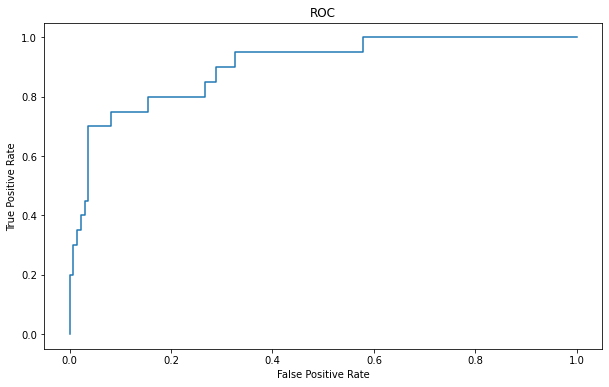

Area Under Curve:  0.9018518518518519


In [168]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = model_log_best_params.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area Under Curve: ',auc)

# 4.3 Random Forest Classifier

## 4.3.1 Random Forest Classifier

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz

In [172]:
X = attributes
y = target
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.25, random_state = 10)


In [173]:
model_rfc = RandomForestClassifier(n_estimators = 10, random_state = 10)
model_rfc.fit(X_train, y_train)
predictions_rfc = model_rfc.predict(X_test)

In [175]:
print('Confusion Matrix: \n',confusion_matrix(y_test, predictions_rfc))
print('Classification Report: \n',classification_report(y_test, predictions_rfc))
print('MCC: ',matthews_corrcoef(y_test, predictions_rfc))


Confusion Matrix: 
 [[131   4]
 [  8  12]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       135
           1       0.75      0.60      0.67        20

    accuracy                           0.92       155
   macro avg       0.85      0.79      0.81       155
weighted avg       0.92      0.92      0.92       155

MCC:  0.6284510371554693


### Comments 
A pretty good start! Let's see if we can improve false positive rate by hyperparameter tuning.

## 4.3.2 Hyperparameters Tuning Through GridSearch

In [177]:
parameters = {'n_estimators':np.arange(1,50), 'max_depth': np.arange(1,10)}
model_rfc_grid = RandomForestClassifier(random_state = 10)
model_rfc_grid_cv = GridSearchCV(model_rfc_grid, parameters, cv=10)
model_rfc_grid_cv.fit(X_test, y_test)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [178]:
print(model_rfc_grid_cv.best_params_)
print(model_rfc_grid_cv.best_score_)

{'max_depth': 7, 'n_estimators': 41}
0.9170833333333335


## 4.3.3. Random Forest Model using hyperparameters from GridSearch

In [199]:
model_rfc_best = RandomForestClassifier(n_estimators = 41, max_depth=7, random_state = 10)
model_rfc_best.fit(X_train, y_train)
predictions_rfc_best = model_rfc_best.predict(X_test)

In [200]:
print(confusion_matrix(y_test, predictions_rfc_best))
print(classification_report(y_test, predictions_rfc_best))
print(matthews_corrcoef(y_test, predictions_rfc_best ))


[[132   3]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       135
           1       0.79      0.55      0.65        20

    accuracy                           0.92       155
   macro avg       0.86      0.76      0.80       155
weighted avg       0.92      0.92      0.92       155

0.6172475973384816


### Comments - to be revised
The F1 score and accuracy are even lower than which wihtout the best hyperparameters 

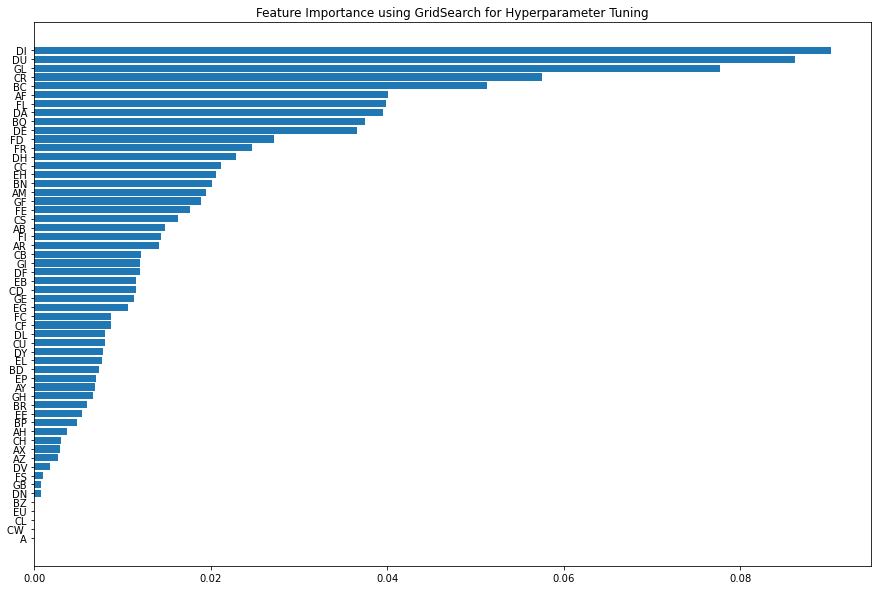

In [181]:
sorted_importances = model_rfc_best.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(attributes.columns[sorted_importances], model_rfc_best.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance using GridSearch for Hyperparameter Tuning')

plt.show()

In [182]:
from sklearn.inspection import permutation_importance
permutation_importance = permutation_importance(model_rfc_best, X_test, y_test)


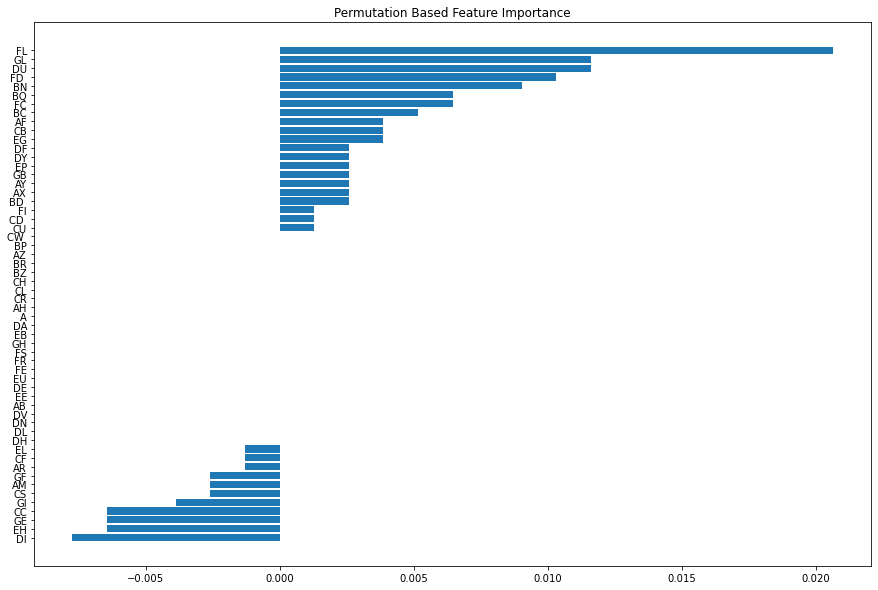

In [183]:
from sklearn.inspection import permutation_importance
permutation_importance = permutation_importance(model_rfc_best, X_test, y_test)
sorted_importances = permutation_importance.importances_mean.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(attributes.columns[sorted_importances], permutation_importance.importances_mean[sorted_importances])
_ = plt.title('Permutation Based Feature Importance')

plt.show()

In [189]:
# removing_features = attributes.drop(['DI', 'EH', 'GE','CC','GI','CS','AM','GF','AR','CF','EL'], axis = 1)

removing_features = attributes.drop(['BZ','EU','CL','A'], axis = 1)

In [201]:
X = removing_features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.25, random_state = 10)
model_rfc_removed_features = RandomForestClassifier(n_estimators = 41, max_depth=7, random_state = 10)
model_rfc_removed_features.fit(X_train, y_train)
predictions_rfc_removed_features = model_rfc_removed_features.predict(X_test)
print('Confusion Matrix: \n',confusion_matrix(y_test, predictions_rfc_removed_features))
print('Classification Report: \n',classification_report(y_test, predictions_rfc_removed_features))
print('MCC:',matthews_corrcoef(y_test, predictions_rfc_removed_features))


Confusion Matrix: 
 [[132   3]
 [ 10  10]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       135
           1       0.77      0.50      0.61        20

    accuracy                           0.92       155
   macro avg       0.85      0.74      0.78       155
weighted avg       0.91      0.92      0.91       155

MCC: 0.5778192149302849


### Comments 
When the negative scored feautres are removed, we don't see a higher false positive score than false negative. 

# 4.4 Gradient Boosting Classifier

In [210]:
from sklearn.ensemble import GradientBoostingClassifier
X = attributes
y = target
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.25, random_state = 10)

## 4.4.1 Gradient Boosting Classifier

In [211]:
model_gb = GradientBoostingClassifier(random_state = 10)
model_gb.fit(X_train, y_train)
predictions_gb = model_gb.predict(X_test)


In [212]:
print(confusion_matrix(y_test, predictions_gb))
print(classification_report(y_test, predictions_gb))
print(matthews_corrcoef(y_test, predictions_gb))

[[130   5]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       135
           1       0.74      0.70      0.72        20

    accuracy                           0.93       155
   macro avg       0.85      0.83      0.84       155
weighted avg       0.93      0.93      0.93       155

0.6776803518828466


## 4.4.2 Hyperparameters Tuning

In [215]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
parameters = {'learning_rate': sp_randFloat(), 
             'subsample': sp_randFloat(),
             'n_estimators': sp_randInt(100,1000),
             'max_depth': sp_randInt(4,10)}

In [216]:
model_gb_cv = RandomizedSearchCV(GradientBoostingClassifier(random_state=10),
                                 parameters,
                                 random_state = 10, 
                                 cv=10, 
                                 n_iter=10, 
                                 n_jobs=-1)

In [217]:
model_gb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=10),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C141659400>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C141664A90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C1412FBC10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C141664A60>},
                   random_state=10)

In [219]:
predictions = model_gb_cv.predict(X_test)

In [220]:
print(model_gb_cv.best_estimator_)
print(model_gb_cv.best_params_)
print(model_gb_cv.best_score_)

GradientBoostingClassifier(learning_rate=0.03061665387269341, max_depth=8,
                           n_estimators=789, random_state=10,
                           subsample=0.9177741225129434)
{'learning_rate': 0.03061665387269341, 'max_depth': 8, 'n_estimators': 789, 'subsample': 0.9177741225129434}
0.9177613320999075


## 4.4.3 Gradient Boosting with Optimal Parameteters

In [222]:
model_gb_best = GradientBoostingClassifier(learning_rate =0.031,
                                           max_depth = 8, 
                                           n_estimators = 789,
                                           subsample = 0.9178,
                                           random_state = 10)
model_gb_best.fit(X_train, y_train)
predictions_gbBest = model_gb_best.predict(X_test)
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions_gbBest))
print('Classification Report: \n', classification_report(y_test, predictions_gbBest))
print('MCC: ', matthews_corrcoef(y_test, predictions_gbBest))


Confusion Matrix: 
 [[130   5]
 [  6  14]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       135
           1       0.74      0.70      0.72        20

    accuracy                           0.93       155
   macro avg       0.85      0.83      0.84       155
weighted avg       0.93      0.93      0.93       155

MCC:  0.6776803518828466


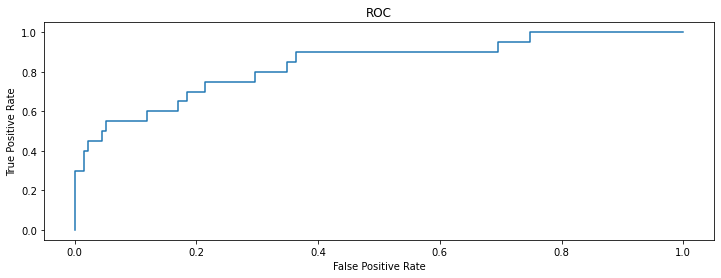

Area Under Curve:  0.8355555555555555


In [223]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = model_gb_best.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area Under Curve: ',auc)

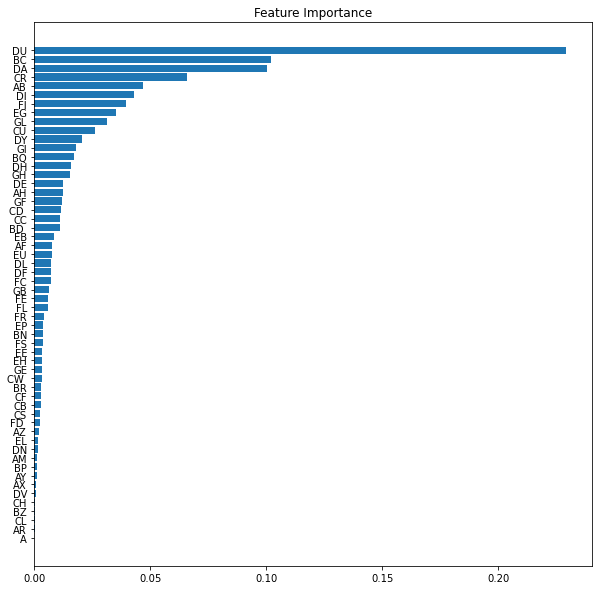

In [227]:
sorted_importances = model_gb_best.feature_importances_.argsort()
_ = plt.figure(figsize=(10,10))
_ = plt.barh(attributes.columns[sorted_importances], model_gb_best.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')

plt.show()

# 4.5 XGBoost Classifier

## 4.5.1 XGBoost Classifier

In [228]:
from xgboost import XGBClassifier
X = attributes
y = target
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.25, random_state = 10)


In [229]:
model_xgb = XGBClassifier(random_state = 10)
model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)

In [230]:
print(confusion_matrix(y_test, predictions_xgb))
print(classification_report(y_test, predictions_xgb))
print(matthews_corrcoef(y_test, predictions_xgb))


[[130   5]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       135
           1       0.75      0.75      0.75        20

    accuracy                           0.94       155
   macro avg       0.86      0.86      0.86       155
weighted avg       0.94      0.94      0.94       155

0.7129629629629629


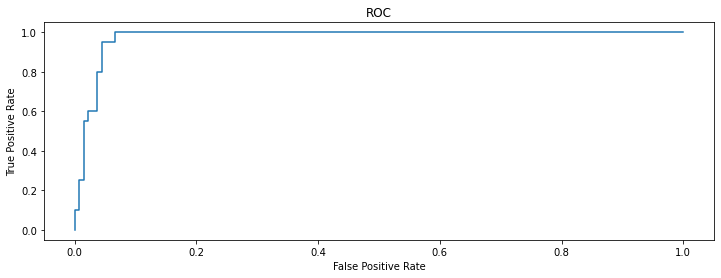

Area Under Curve:  0.975925925925926


In [231]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = model_xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area Under Curve: ',auc)

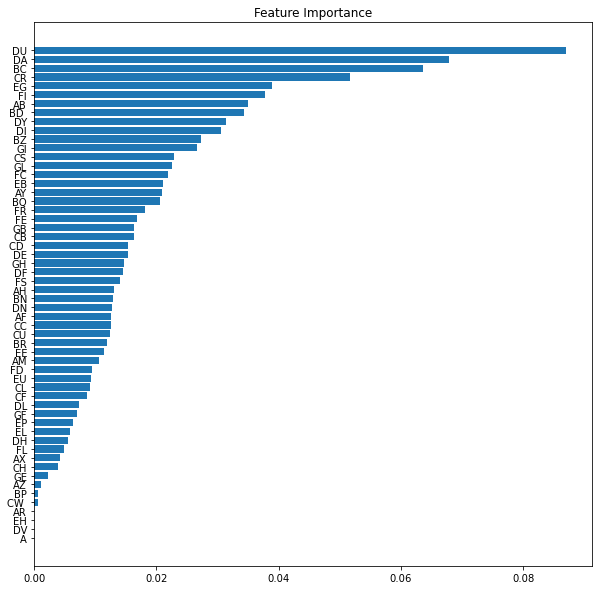

In [232]:
sorted_importances = model_xgb.feature_importances_.argsort()
_ = plt.figure(figsize=(10,10))
_ = plt.barh(attributes.columns[sorted_importances], model_xgb.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
plt.show()

## 4.5.2 Hyperparameter Tuning

In [233]:
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}
model_xgb_cv =RandomizedSearchCV(XGBClassifier(random_state=10),
                                 parameters,
                                 cv=10, 
                                 n_jobs=-1)
model_xgb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           num_parallel_tree=None,
                            

In [234]:
print(model_xgb_cv.best_estimator_)
print('\n')
print(model_xgb_cv.best_params_)
print('\n')
print(model_xgb_cv.best_score_)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', predictor=None, ...)


{'reg_lambda': 5, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 600, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


0.8938945420906567


## 4.5.3 XGBoost with Optimal Parameters

In [235]:
model_xgb_best = XGBClassifier(random_state = 10, reg_lambda= 5, reg_alpha = 1, objective = 'reg:squarederror',
                               n_estimators= 600, min_child_weight= 15, max_depth= 7, 
                               learning_rate = 0.1, gamma = 1, colsample_bytree= 0.9, 
                               booster = 'gbtree')
model_xgb_best.fit(X_train, y_train)
predictions_xgb_best = model_xgb_best.predict(X_test)
print('Confusion Matrix: \n',confusion_matrix(y_test, predictions_xgb_best))
print('Classification Report: \n',classification_report(y_test, predictions_xgb_best))
print('MCC: ',matthews_corrcoef(y_test, predictions_xgb_best))


Confusion Matrix: 
 [[129   6]
 [  8  12]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       135
           1       0.67      0.60      0.63        20

    accuracy                           0.91       155
   macro avg       0.80      0.78      0.79       155
weighted avg       0.91      0.91      0.91       155

MCC:  0.5813167553459632


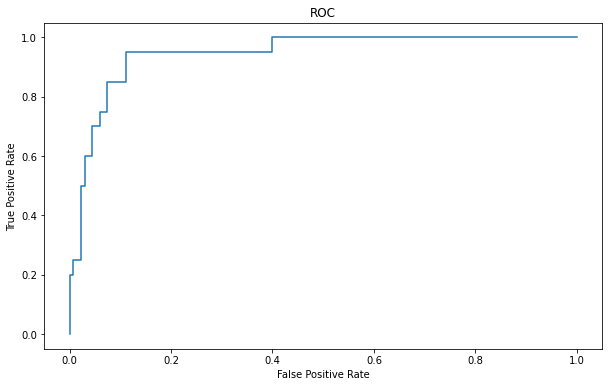

Area Under Curve:  0.9451851851851851


In [236]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = model_xgb_best.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area Under Curve: ',auc)

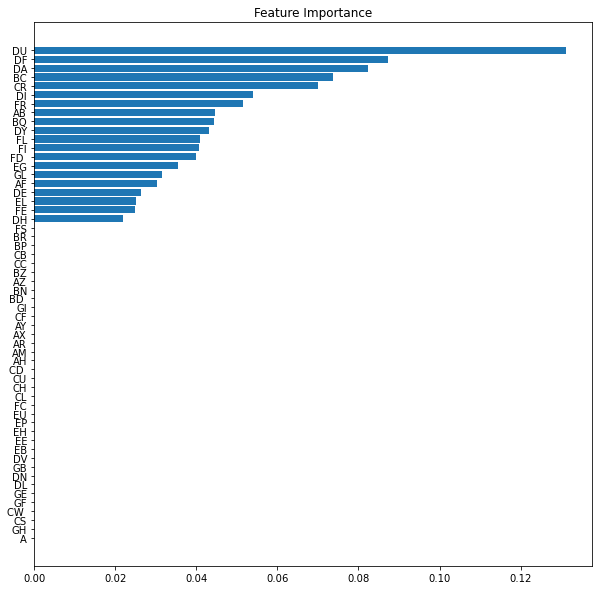

In [238]:
sorted_importances = model_xgb_best.feature_importances_.argsort()
_ = plt.figure(figsize=(10,10))
_ = plt.barh(attributes.columns[sorted_importances], model_xgb_best.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
plt.show()

# 5. Model Selection - to be revised 

In [240]:
evaluation_parameters = ['Model','FP > FN', 'Accuracy', ' MCC', 'AUC', 'Important Features']
summary_df = pd.DataFrame(columns=evaluation_parameters)
data = [pd.Series(['Logistic Regression', 'No', 0.98, 0.9549, 0.9989, 'N/A'], index=summary_df.columns),
       pd.Series(['Random Forest', 'No', 0.99, 0.970, 0.9,'concave points mean, concave points worst, area worst'], index= summary_df.columns),
       pd.Series(['Gradient Boosting', 'Yes', 0.98, 0.9562, 0.9466, 'perimeter worst, concave points worst, texture worst'], index = summary_df.columns),
       pd.Series(['XGBoost', 'No', 0.98, 0.95, 0.99, 'perimeter worst, radius worst, concave points worst'], index = summary_df.columns)]
summary_df2 = summary_df.append(data, ignore_index = True)

summary_df2

,Model,FP > FN,Accuracy,MCC,AUC,Important Features
0,Logistic Regression,No,0.98,0.9549,0.9989,N/A
1,Random Forest,No,0.99,0.9700,0.9000,"concave points mean, concave points worst, are..."
2,Gradient Boosting,Yes,0.98,0.9562,0.9466,"perimeter worst, concave points worst, texture..."
3,XGBoost,No,0.98,0.9500,0.9900,"perimeter worst, radius worst, concave points ..."


In [241]:
Summary_findings = summary_df2.set_index('Model')
Summary_findings

,FP > FN,Accuracy,MCC,AUC,Important Features
Model,,,,,
Logistic Regression,No,0.98,0.9549,0.9989,N/A
Random Forest,No,0.99,0.9700,0.9000,"concave points mean, concave points worst, are..."
Gradient Boosting,Yes,0.98,0.9562,0.9466,"perimeter worst, concave points worst, texture..."
XGBoost,No,0.98,0.9500,0.9900,"perimeter worst, radius worst, concave points ..."
